Get node labels

In [1]:
import sys
sys.path.append('..')
import data_utils
sys.path.append(data_utils.join_base_path('reallaborai4u/preprocessing'))
from feature_names import NON_CONDITIONAL_FEAT as LABELS
PRINT_LABELS = [l.removeprefix('EMA_') for l in LABELS]

Settings

In [2]:
SAVE = False

VERSION = 'empirical covariance' #'Empirical Covariance'  # 'Pseudoinverse', 'Gaussian Obs Model'

### PLRNN

Calculate cumulative impulse responses for inputs targeted at single nodes

In [3]:
import sys
sys.path.append('..')
import os
import torch as tc
import matplotlib.pyplot as plt
import eval_reallabor_utils
import data_utils
import utils
from plotting_styles import PaperStyle, colors
from bptt.plrnn import PLRNN

MRT = [2, 3]
T = 7

os.makedirs('../results/_paper/network_perturbation_analyses', exist_ok=True)
errors_loading_model = 0
with PaperStyle(settings={'axes.grid':False}):

    plrnn_out_centrality = []
    plrnn_abs_out_centrality = []
    plrnn_cir = []
    plrnn_input_selectivity_new = []
    plrnn_input_selectivity_old = []
    
    for mrt in MRT:

        results_dir = data_utils.join_ordinal_bptt_path('results', f'v3_MRT{mrt}_every_day')
        test_data_dir = data_utils.dataset_path(mrt, 'processed_csv_no_con')
        mrt_out_centrality = []
        mrt_abs_out_centrality = []
        mrt_cir = []
        mrt_input_selectivity_new = []
        mrt_input_selectivity_old = []

        print(f'Collecting models for MRT {mrt}....')
        models = eval_reallabor_utils.ModelCatalogue(results_dir, only_valid_days=False)
        networks = []
        print(f'Perturbation analysis for MRT {mrt}....')
        for p, df in data_utils.zip_participants_data(test_data_dir):
            model_dir = models.get_best_latest_model_dir(p, timestep=1000)
            if model_dir is None:
                continue
            args = utils.load_args(model_dir)
            model = PLRNN()
            model.init_from_model_path(model_dir)
            try:
                Gamma, B = eval_reallabor_utils.get_Gamma_and_B(model, model_dir, version=VERSION)
            except:
                errors_loading_model += 1
                continue
            x = tc.tensor(df[LABELS].to_numpy()).float()
            network = eval_reallabor_utils.get_network_matrix(model, x, Gamma=Gamma, B=B).nanmean(0)
            model_out_centrality = eval_reallabor_utils.weighted_degree_centrality(network, mode='out', absolute=False)
            model_abs_out_centrality = eval_reallabor_utils.weighted_degree_centrality(network, mode='out', absolute=True)
            perturb_nodes = tc.arange(len(model_out_centrality))
            C = model.get_parameters()['C']
            
            model_cir = []
            model_input_selectivity_new = []
            model_input_selectivity_old = []
            x0 = tc.cat((tc.eye(x.shape[1]).float(), tc.zeros(x.shape[1]).float().unsqueeze(0)), 0)
            for i, item in enumerate(perturb_nodes):
                ## Old version of perturbation:
                B_reduced = B[item]
                if B_reduced.ndim == 1:
                    B_reduced = B_reduced.unsqueeze(0)
                M = B_reduced @ C
                kernel_basis, compl_basis = eval_reallabor_utils.split_basis_into_kernel_and_orthogonal_complement(M)
                perturbation_old = compl_basis.mean(dim=1) * 1
                subject_input_selectivity_old = eval_reallabor_utils.impulse_selectivity_score(B, C, perturbation_old, item).detach()
                ## New version of perturbation 
                perturbation = eval_reallabor_utils.target_input_on_node(B, C, item)
                subject_input_selectivity_new = eval_reallabor_utils.impulse_selectivity_score(B, C, perturbation, item).detach()
                subject_cir = eval_reallabor_utils.impulse_response(model, perturbation, T, cumulative=True, relative=True, x0=x0, 
                                                                    Gamma=Gamma, B=B).mean(axis=0)     # mean over initial conditions
                model_cir.append(subject_cir)
                model_input_selectivity_new.append(subject_input_selectivity_new)
                model_input_selectivity_old.append(subject_input_selectivity_old)
            model_cir = tc.stack(model_cir, dim=0)
            mrt_cir.append(model_cir)
            model_input_selectivity_new = tc.stack(model_input_selectivity_new, dim=0)
            mrt_input_selectivity_new.append(model_input_selectivity_new)
            model_input_selectivity_old = tc.stack(model_input_selectivity_old, dim=0)
            mrt_input_selectivity_old.append(model_input_selectivity_old)
            mrt_out_centrality.append(model_out_centrality)
            mrt_abs_out_centrality.append(model_abs_out_centrality)

        mrt_cir = tc.stack(mrt_cir, dim=0)
        plrnn_cir.append(mrt_cir)
        mrt_input_selectivity_new = tc.stack(mrt_input_selectivity_new, dim=0)
        plrnn_input_selectivity_new.append(mrt_input_selectivity_new)
        mrt_input_selectivity_old = tc.stack(mrt_input_selectivity_old, dim=0)
        plrnn_input_selectivity_old.append(mrt_input_selectivity_old)
        mrt_out_centrality = tc.stack(mrt_out_centrality, dim=0)
        mrt_abs_out_centrality = tc.stack(mrt_abs_out_centrality, dim=0)
        plrnn_out_centrality.append(mrt_out_centrality)
        plrnn_abs_out_centrality.append(mrt_abs_out_centrality)

if errors_loading_model > 0:
    print(f'Errors loading model: {errors_loading_model}')
### dims of plrnn_cir: (mrt, subject, perturb_node, feature)
### dims of plrnn_out_centrality: (mrt, subject, perturb_node)

Perturbation analysis for MRT 2....
Perturbation analysis for MRT 3....
Errors loading model: 1


In [4]:
from scipy import stats

for m, mrt in enumerate(MRT):
    print(f'New selectivity mean MRT {mrt}: {plrnn_input_selectivity_new[m].mean()}')
    print(f'Old selectivity mean MRT {mrt}: {plrnn_input_selectivity_old[m].mean()}')

    selectivity_test = stats.ttest_rel(plrnn_input_selectivity_new[m].mean(1), plrnn_input_selectivity_old[m].mean(1))
    print(f'Selectivity t-test MRT {mrt}: t={selectivity_test.statistic}, p={selectivity_test.pvalue}')

New selectivity mean MRT 2: 0.2158830463886261
Old selectivity mean MRT 2: 0.13503612577915192
Selectivity t-test MRT 2: t=26.047921962040352, p=2.983076037757134e-32
New selectivity mean MRT 3: 0.2160782665014267
Old selectivity mean MRT 3: 0.12960053980350494
Selectivity t-test MRT 3: t=36.504985232951725, p=1.0320762819468166e-41


Plot out centrality of nodes against cumulative impulse reponse

Low vs. high rank nodes t-test MRT 2: t(54)=-4.508841873333512, p=3.546915644407708e-05
Correlation between out centrality rank and rCIR:
MRT 2, rank r=0.889, p=0.000
Low vs. high rank nodes t-test MRT 3: t(58)=-4.874173608557506, p=8.843346637973798e-06
Correlation between out centrality rank and rCIR:
MRT 3, rank r=0.829, p=0.000


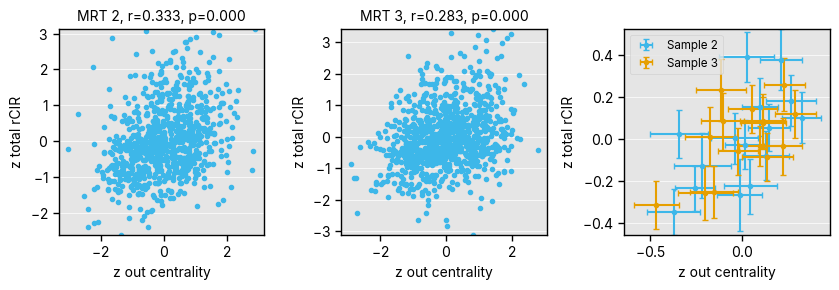

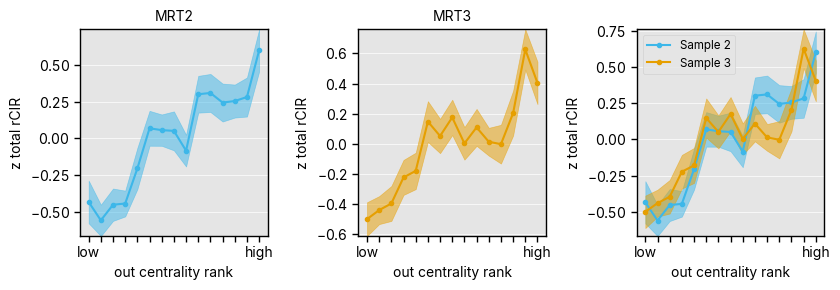

In [14]:
from scipy import stats
import math

take_absolute_cir = False
standardize_cir = True
standardize_centrality = True
cir = plrnn_cir.copy()
out_centrality = plrnn_out_centrality.copy()

color_cycle = colors.color_cycle[:2]#["#3DB7E9", "#e69f00"]
with PaperStyle():
    fig1, axes1 = plt.subplots(1, 3, figsize=(8.5, 3), sharey=False)
    fig2, axes2 = plt.subplots(1, 3, figsize=(8.5, 3), sharey=False)
    for m, mrt in enumerate(MRT):
        valid_map = ~cir[m].mean(2).isnan().any(1)
        # standardize out centrality over nodes
        if standardize_centrality:
            z_out_centrality = (out_centrality[m] - out_centrality[m].mean(1, keepdim=True)) / out_centrality[m].std(1, keepdim=True)
            label_out_centrality = 'z out centrality'
        else:
            z_out_centrality = out_centrality[m]
            label_out_centrality = 'out centrality'
        z_out_centrality = z_out_centrality[valid_map]
        # standardize cir over perturb_nodes
        if take_absolute_cir:
            cir_mean = tc.abs(cir[m]).mean(2)[valid_map]
            label_cir = 'total abs rCIR'
        else:
            cir_mean = cir[m].mean(2)[valid_map]
            label_cir = 'total rCIR'
        if standardize_cir:
            z_total_cir = (cir_mean - cir_mean.mean(1, keepdim=True)) / cir_mean.std(1, keepdim=True)
            label_cir = 'z ' + label_cir
        else:
            z_total_cir = cir_mean
        pearsonr = stats.pearsonr(z_out_centrality.flatten(), z_total_cir.flatten())
        r, p = pearsonr.correlation, pearsonr.pvalue
        axes1[m].plot(z_out_centrality.flatten(), z_total_cir.flatten(), linestyle='', marker='.')
        axes1[m].set(xlabel=label_out_centrality, ylabel=label_cir, title=f'MRT {mrt}, r={r:.3f}, p={p:.3f}')
        axes1[2].errorbar(z_out_centrality.mean(0), z_total_cir.mean(0), 
                          yerr=z_total_cir.std(0)/math.sqrt(z_total_cir.shape[0]), 
                          xerr=z_out_centrality.std(0)/math.sqrt(z_out_centrality.shape[0]), color=color_cycle[m], linestyle='', marker='.', label=f'Sample {mrt}')
        axes1[2].set(xlabel=label_out_centrality, ylabel=label_cir)
        axes1[2].legend()
        fig1.tight_layout()

        ordered_cir_mean = z_total_cir.take_along_dim(z_out_centrality.argsort(), dim=1)
        ordered_cir_mean_mean = ordered_cir_mean.mean(0)
        ordered_cir_mean_sem = ordered_cir_mean.std(0) / math.sqrt(ordered_cir_mean.shape[0])
        rankcorr = stats.spearmanr(range(ordered_cir_mean.shape[1]), ordered_cir_mean_mean)
        r, p = rankcorr.correlation, rankcorr.pvalue
        axes2[m].plot(tc.arange(ordered_cir_mean.shape[1])+1, ordered_cir_mean_mean, linestyle='-', marker='.', color=color_cycle[m])
        axes2[m].fill_between(tc.arange(ordered_cir_mean.shape[1])+1, ordered_cir_mean_mean - ordered_cir_mean_sem, ordered_cir_mean_mean + ordered_cir_mean_sem, alpha=0.5, color=color_cycle[m])
        axes2[m].set(xlabel='out centrality rank', ylabel=label_cir, title=f'MRT{mrt}')
        axes2[m].set_xticks(tc.arange(ordered_cir_mean.shape[1])+1, labels=['low']+['']*(ordered_cir_mean.shape[1]-2)+['high'])
        axes2[2].plot(tc.arange(ordered_cir_mean.shape[1])+1, ordered_cir_mean_mean, linestyle='-', marker='.', color=color_cycle[m], label=f'Sample {mrt}')
        axes2[2].fill_between(tc.arange(ordered_cir_mean.shape[1])+1, ordered_cir_mean_mean - ordered_cir_mean_sem, ordered_cir_mean_mean + ordered_cir_mean_sem, alpha=0.5, color=color_cycle[m])
        axes2[2].set(xlabel='out centrality rank', ylabel=label_cir)
        axes2[2].set_xticks(tc.arange(ordered_cir_mean.shape[1])+1, labels=['low']+['']*(ordered_cir_mean.shape[1]-2)+['high'])
        axes2[2].legend()
        fig2.tight_layout()

        # Test highest vs lowest rank node rCIRs
        high_rank_nodes = ordered_cir_mean[:, 0]
        low_rank_nodes = ordered_cir_mean[:, -1]
        rank_nodes_test = stats.ttest_rel(high_rank_nodes, low_rank_nodes)
        print(f'Low vs. high rank nodes t-test MRT {mrt}: t({rank_nodes_test.df})={rank_nodes_test.statistic}, p={rank_nodes_test.pvalue}')

        print('Correlation between out centrality rank and rCIR:')
        print(f'MRT {mrt}, rank r={r:.3f}, p={p:.3f}')
    if SAVE:
        fig2.savefig(f'../results/_paper/network_perturbation_analyses/plrnn_cir_vs_out_centrality_rank.svg')
    plt.show()

In [ ]:
ordered_cir_mean.diff(dim=1) 

tensor([[-1.0892e+00, -3.7093e-01, -1.4821e-01,  7.1824e-02,  4.8647e-01,
          1.3666e-01, -7.1402e-01,  4.6023e-01, -5.6230e-02,  6.0564e-01,
         -6.3014e-01,  5.6805e-01,  3.0960e+00, -3.3336e+00],
        [-8.9258e-01,  8.8159e-01,  4.4146e-01, -1.9810e+00, -2.7124e-01,
         -8.7135e-01,  1.0483e+00,  6.0825e-01,  6.3190e-01, -1.6449e+00,
          1.0921e+00, -6.1596e-01, -1.2094e+00,  3.5595e-01],
        [ 1.9567e-01, -3.1372e-01, -2.1779e-01,  7.1596e-02,  3.1801e+00,
         -2.2809e+00, -9.8358e-01,  8.1078e-01,  1.3674e+00, -4.7097e-01,
         -1.8272e+00,  2.3481e+00, -1.7331e+00,  4.5197e-01],
        [ 1.6137e-01,  1.7487e+00, -3.8346e-01,  4.8675e-01, -5.6550e-04,
         -7.2226e-01,  1.0110e+00, -1.0051e+00,  3.0520e+00, -2.5185e+00,
         -4.5396e-01,  4.9878e-01,  3.0676e-01, -1.1039e+00],
        [-3.0216e-01,  4.5848e-01, -4.1722e-01,  3.2180e-01, -7.6787e-01,
         -2.6426e-01, -3.0565e-01, -3.0114e-02,  3.3269e-01,  5.9969e-01,
          9.

Plot cumulative impulse response, centrality, and selectivity for each node, everything standardized

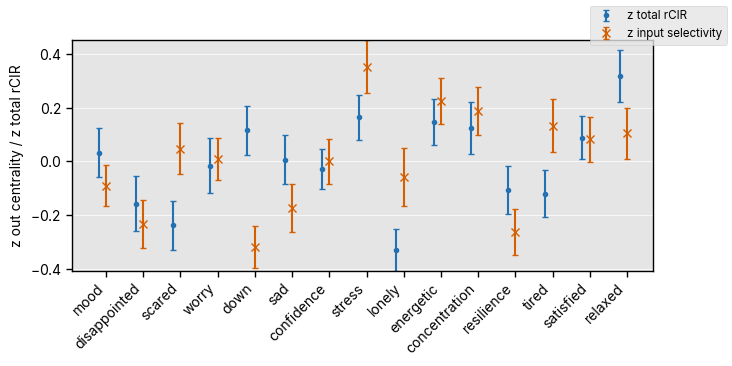

In [13]:
from scipy import stats
import math

plot = {'cir': True, 'centrality': False, 'selectivity': True}

take_absolute_cir = False
cir = plrnn_cir.copy()
out_centrality = plrnn_out_centrality.copy()
selectivity = plrnn_input_selectivity_new.copy()

out_centrality = tc.concat(out_centrality, dim=0)
cir = tc.concat(cir, dim=0)
selectivity = tc.concat(selectivity, dim=0)

color_cycle = colors.color_cycle
with PaperStyle():
    fig, ax = plt.subplots(1, 1, figsize=(7.5, 3))
    offset = -0.2
    valid_map = ~cir.mean(2).isnan().any(1)
    z_out_centrality = (out_centrality - out_centrality.mean(1, keepdim=True)) / out_centrality.std(1, keepdim=True)
    label_out_centrality = 'z out centrality'
    z_out_centrality = z_out_centrality[valid_map]
    centr_participant_mean = z_out_centrality.mean(0)
    centr_participant_sem = z_out_centrality.std(0) / math.sqrt(z_out_centrality.shape[0])
    if take_absolute_cir:
        cir_mean = tc.abs(cir).mean(2)[valid_map]
        label_cir = 'z total abs rCIR'
    else:
        cir_mean = cir.mean(2)[valid_map]
        label_cir = 'z total rCIR'
    z_total_cir = (cir_mean - cir_mean.mean(1, keepdim=True)) / cir_mean.std(1, keepdim=True)
    cir_participant_mean = z_total_cir.mean(0)
    cir_participant_sem = z_total_cir.std(0) / math.sqrt(z_total_cir.shape[0])
    z_selectivity = (selectivity - selectivity.mean(1, keepdim=True)) / selectivity.std(1, keepdim=True)
    selectivity_participant_mean = z_selectivity.mean(0)
    selectivity_participant_sem = z_selectivity.std(0) / math.sqrt(z_selectivity.shape[0])

    cidx = 4
    if plot['centrality']:
        ax.errorbar(tc.arange(len(PRINT_LABELS)) + offset, centr_participant_mean, yerr=centr_participant_sem, linestyle='', marker='v', color=color_cycle[cidx], label=label_out_centrality)
        cidx += 1; offset += 0.2
    if plot['cir']:
        ax.errorbar(tc.arange(len(PRINT_LABELS)) + offset, cir_participant_mean, yerr=cir_participant_sem, linestyle='', marker='.', color=color_cycle[cidx], label=label_cir)
        cidx += 1; offset += 0.2
    if plot['selectivity']:
        ax.errorbar(tc.arange(len(PRINT_LABELS)) + offset, selectivity_participant_mean, yerr=selectivity_participant_sem, linestyle='', marker='x', color=color_cycle[cidx], label='z input selectivity')
    ax.set(ylabel=f'{label_out_centrality} / {label_cir}')
    ax.set_xticks(tc.arange(len(PRINT_LABELS)), PRINT_LABELS, rotation=45, ha='right')
    fig.legend()
    if SAVE:
        fig2.savefig(f'../results/_paper/network_perturbation_analyses/plrnn_cir_next_to_out_centrality_next_to_selectivity.svg')
    plt.show()

Just rCIR

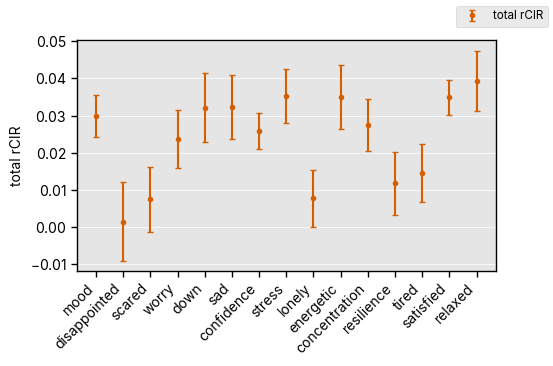

In [14]:
from scipy import stats
import math
from plotting_utils import adjust_ylim

take_absolute_cir = False
standardize_cir = False
cir = plrnn_cir.copy()

cir = tc.concat(cir, dim=0)

color_cycle = colors.color_cycle
with PaperStyle():
    fig, ax = plt.subplots(1, 1, figsize=(5.4, 3))
    valid_map = ~cir.mean(2).isnan().any(1)
    if take_absolute_cir:
        cir_mean = tc.abs(cir).mean(2)[valid_map]
        label_cir = 'total abs rCIR'
    else:
        cir_mean = cir.mean(2)[valid_map]
        label_cir = 'total rCIR'
    if standardize_cir:
        z_total_cir = (cir_mean - cir_mean.mean(1, keepdim=True)) / cir_mean.std(1, keepdim=True)
        label_cir = 'z ' + label_cir
    else:
        z_total_cir = cir_mean
    cir_participant_mean = z_total_cir.mean(0)
    cir_participant_sem = z_total_cir.std(0) / math.sqrt(z_total_cir.shape[0])
    ax.set(ylabel=label_cir)    
    ax.errorbar(tc.arange(len(PRINT_LABELS)), cir_participant_mean, yerr=cir_participant_sem, linestyle='', marker='.', color=color_cycle[5], label=label_cir)
    ax.set_xticks(tc.arange(len(PRINT_LABELS)), PRINT_LABELS, rotation=45, ha='right')
    adjust_ylim(ax)
    fig.legend()
    if SAVE:
        fig.savefig(f'../results/_paper/network_perturbation_analyses/plrnn_cir.svg')
    plt.show()

Just selectivity

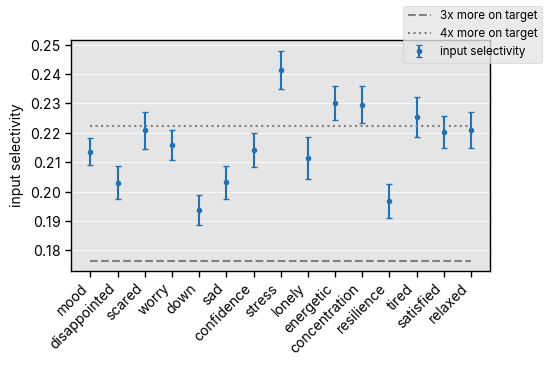

In [15]:
from scipy import stats
import math
from plotting_utils import adjust_ylim

selectivity = plrnn_input_selectivity_new.copy()
selectivity = tc.concat(selectivity, dim=0)

color_cycle = colors.color_cycle
with PaperStyle():
    fig, ax = plt.subplots(1, 1, figsize=(5.4, 3))
    selectivity_participant_mean = selectivity.mean(0)
    selectivity_participant_sem = selectivity.std(0) / math.sqrt(selectivity.shape[0])
    triple_selectivity = 3 / (selectivity.shape[1]+2)
    quadruple_selectivity = 4 / (selectivity.shape[1]+3)
    # quintuple_selectivity = 5 / (selectivity.shape[1]+4)
    ax.set(ylabel='input selectivity')    
    ax.errorbar(tc.arange(len(PRINT_LABELS)), selectivity_participant_mean, yerr=selectivity_participant_sem, linestyle='', marker='.', color=color_cycle[4], label='input selectivity')
    x_lim = [0, len(PRINT_LABELS)-1]
    ax.plot(x_lim, [triple_selectivity, triple_selectivity], linestyle='--', color='gray', label='3x more on target')
    ax.plot(x_lim, [quadruple_selectivity, quadruple_selectivity], linestyle=':', color='gray', label='4x more on target')
    # ax.plot(x_lim, [quintuple_selectivity, quintuple_selectivity], linestyle='--', color='blue', label='5x more on target')
    ax.set_xticks(tc.arange(len(PRINT_LABELS)), PRINT_LABELS, rotation=45, ha='right')
    adjust_ylim(ax)
    fig.legend()
    if SAVE:
        fig.savefig(f'../results/_paper/network_perturbation_analyses/plrnn_input_selectivity.svg')
    plt.show()

Plot cumulative impulse response of node with highest and lowest out centrality

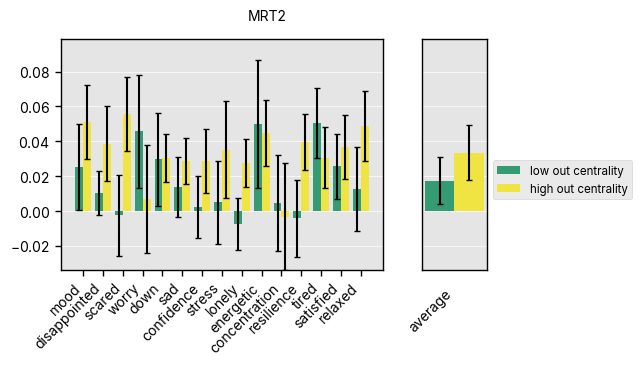

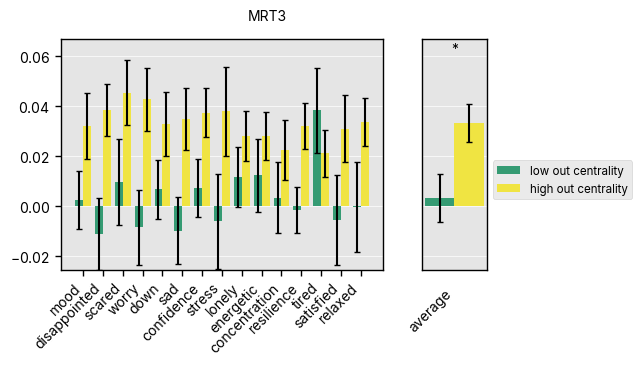

In [16]:
import math
from scipy import stats
import plotting_utils
from eval_reallabor_utils import bonferroni_holm_correction

take_absolute_cir = False
standardize_over_dims = None
cir = plrnn_cir
out_centrality = plrnn_out_centrality

with PaperStyle():

    for m, mrt in enumerate(MRT):
        fig, axes = plt.subplots(1, 2, figsize=(5.5, 3), gridspec_kw={'width_ratios':[5,1]}, sharey=True)
        # valid_map = ~cir[m].mean(2).isnan().any(1)
        # z_out_centrality = (out_centrality[m] - out_centrality[m].mean(1, keepdim=True)) / out_centrality[m].std(1, keepdim=True)  
        z_out_centrality = out_centrality[m]
        if take_absolute_cir:
            z_cir = tc.abs(cir[m])    
        else:
            z_cir = cir[m]
        if standardize_over_dims is not None:
            z_cir = (z_cir - z_cir.mean(standardize_over_dims, keepdim=True)) / z_cir.std(standardize_over_dims, keepdim=True)
        high_centrality_nodes = tc.argmax(z_out_centrality, dim=1)
        low_centrality_nodes = tc.argmin(z_out_centrality, dim=1)

        cir_of_high_centrality_nodes = z_cir[tc.arange(z_cir.shape[0]), high_centrality_nodes]
        cir_of_low_centrality_nodes = z_cir[tc.arange(z_cir.shape[0]), low_centrality_nodes]
        stacked_cir = tc.stack((cir_of_low_centrality_nodes, cir_of_high_centrality_nodes), dim=0).detach().numpy()
        pvalues = stats.ttest_rel(cir_of_low_centrality_nodes, cir_of_high_centrality_nodes).pvalue
        pvalues = bonferroni_holm_correction(pvalues)

        plotting_utils.bars(stacked_cir.mean(1), ax=axes[0], yerr=stats.sem(stacked_cir, axis=1), color=colors.color_cycle[2:])
        plotting_utils.adjust_ylim(axes[0], 0.1, 0)
        ylim = axes[0].get_ylim()       
        for i, p in enumerate(pvalues):
            if p<0.001:
                axes[0].text(i, 0.95*ylim[1], '**', ha='center', va='bottom')
            elif p<0.05:
                axes[0].text(i, 0.9*ylim[1], '*', ha='center', va='bottom')
        axes[0].set_xticks(range(z_cir.shape[2]), labels=PRINT_LABELS, rotation=45, ha='right')

        plotting_utils.bars(stacked_cir.mean((1,2)), ax=axes[1], yerr=stats.sem(stacked_cir.mean(2), axis=1), color=colors.color_cycle[2:])
        axes[1].legend(['low out centrality', 'high out centrality'], bbox_to_anchor=(1, 0.5))
        axes[1].tick_params(bottom=False, left=False)
        axes[1].set_xlabel('average', rotation=45, ha='right')
        p = stats.ttest_rel(stacked_cir[0].mean(1), stacked_cir[1].mean(1)).pvalue
        if p<0.001:
            axes[1].text(0, 0.9*ylim[1], '**', ha='center', va='bottom')
        elif p<0.05:
            axes[1].text(0, 0.9*ylim[1], '*', ha='center', va='bottom')
        fig.suptitle(f'MRT{mrt}')
        if SAVE:
            fig.savefig(f'../results/_paper/network_perturbation_analyses/plrnn_cir_hi_lo_centrality_mrt{mrt}.svg')
    plt.show()


For both MRTs combined

rCIR of high vs low out centrality nodes:
t(113)=-2.0469125837569346, p=0.043


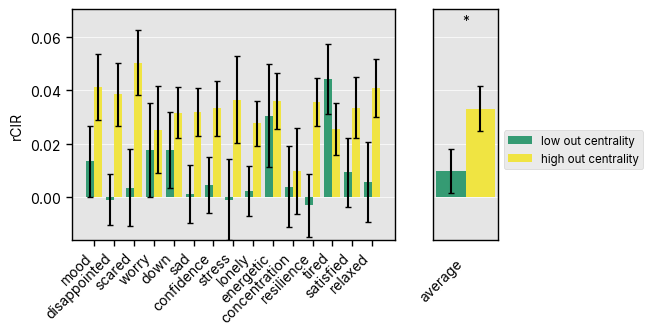

In [17]:
import math
from scipy import stats
import plotting_utils
from eval_reallabor_utils import bonferroni_holm_correction


take_absolute_cir = False
standardize_over_dims = None
cir = plrnn_cir.copy()
out_centrality = plrnn_out_centrality.copy()

out_centrality = tc.concat(out_centrality, dim=0)
cir = tc.concat(cir, dim=0)

with PaperStyle():

    fig, axes = plt.subplots(1, 2, figsize=(5.5, 3), gridspec_kw={'width_ratios':[5,1]}, sharey=True)
    z_out_centrality = out_centrality
    if take_absolute_cir:
        z_cir = tc.abs(cir)    
        label_cir = 'abs rCIR'
    else:
        z_cir = cir
        label_cir = 'rCIR'
    if standardize_over_dims is not None:
        z_cir = (z_cir - z_cir.mean(standardize_over_dims, keepdim=True)) / z_cir.std(standardize_over_dims, keepdim=True)
    high_centrality_nodes = tc.argmax(z_out_centrality, dim=1)
    low_centrality_nodes = tc.argmin(z_out_centrality, dim=1)

    cir_of_high_centrality_nodes = z_cir[tc.arange(z_cir.shape[0]), high_centrality_nodes]
    cir_of_low_centrality_nodes = z_cir[tc.arange(z_cir.shape[0]), low_centrality_nodes]
    stacked_cir = tc.stack((cir_of_low_centrality_nodes, cir_of_high_centrality_nodes), dim=0).detach().numpy()
    pvalues = stats.ttest_rel(cir_of_low_centrality_nodes, cir_of_high_centrality_nodes).pvalue
    pvalues = bonferroni_holm_correction(pvalues)

    plotting_utils.bars(stacked_cir.mean(1), ax=axes[0], yerr=stats.sem(stacked_cir, axis=1), color=colors.color_cycle[2:])
    plotting_utils.adjust_ylim(axes[0], 0.1, 0)
    ylim = axes[0].get_ylim()       
    for i, p in enumerate(pvalues):
        if p<0.001:
            axes[0].text(i, 0.9*ylim[1], '**', ha='center', va='bottom')
        elif p<0.05:
            axes[0].text(i, 0.9*ylim[1], '*', ha='center', va='bottom')
    axes[0].set_xticks(range(z_cir.shape[2]), labels=PRINT_LABELS, rotation=45, ha='right')
    axes[0].set_ylabel(label_cir)

    plotting_utils.bars(stacked_cir.mean((1,2)), ax=axes[1], yerr=stats.sem(stacked_cir.mean(2), axis=1), color=colors.color_cycle[2:])
    axes[1].legend(['low out centrality', 'high out centrality'], bbox_to_anchor=(1, 0.5))
    axes[1].tick_params(bottom=False, left=False)
    axes[1].set_xlabel('average', rotation=45, ha='right')
    test_result = stats.ttest_rel(stacked_cir[0].mean(1), stacked_cir[1].mean(1))
    p = test_result.pvalue
    if p<0.001:
        axes[1].text(0, 0.9*ylim[1], '**', ha='center', va='bottom')
    elif p<0.05:
        axes[1].text(0, 0.9*ylim[1], '*', ha='center', va='bottom')

    print(f'{label_cir} of high vs low out centrality nodes:')
    print(f't({test_result.df})={test_result.statistic}, p={p:.3f}')
    stats.ttest_rel(stacked_cir[0].mean(1), stacked_cir[1].mean(1))
    if SAVE:
        fig.savefig(f'../results/_paper/network_perturbation_analyses/plrnn_cir_hi_lo_centrality.svg')
    plt.show()


In [18]:
stats.ttest_rel(stacked_cir[0].mean(1), stacked_cir[1].mean(1))

TtestResult(statistic=np.float64(-2.0469125837569346), pvalue=np.float64(0.04298644918240401), df=np.int64(113))

### KalmanFilter

Calculate cumulative impulse responses for inputs targeted at single nodes

In [19]:
import sys
sys.path.append('..')
import os
import torch as tc
import matplotlib.pyplot as plt
import eval_reallabor_utils
import data_utils
import utils
from plotting_styles import PaperStyle
from comparison_models.simple_models.models import KalmanFilter

MRT = [2, 3]
T = 7

os.makedirs('../results/_paper/network_perturbation_analyses', exist_ok=True)
with PaperStyle(settings={'axes.grid':False}):

    kalman_out_centrality = []
    kalman_cir = []
    
    for mrt in MRT:

        results_dir = data_utils.join_ordinal_bptt_path('results', f'v2_MRT{mrt}_Kalman_every_day')
        test_data_dir = data_utils.dataset_path(mrt, 'processed_csv_no_con')
        mrt_out_centrality = []
        mrt_cir = []

        print(f'Collecting models for MRT {mrt}....')
        models = eval_reallabor_utils.ModelCatalogue(results_dir)
        networks = []
        print(f'Perturbation analysis for MRT {mrt}....')
        for p, df in data_utils.zip_participants_data(test_data_dir):
            model_dir = models.get_best_latest_model_dir(p, timestep=1000)
            if model_dir is None:
                continue
            args = utils.load_args(model_dir)
            model = KalmanFilter(args)
            model.init_from_model_path(model_dir)
            x = tc.tensor(df[LABELS].to_numpy()).float()
            network = eval_reallabor_utils.get_network_matrix(model, x)
            model_out_centrality = eval_reallabor_utils.weighted_degree_centrality(network, mode='out', absolute=False)
            # perturb_nodes = tc.argsort(model_out_centrality)[[-1, 0]]
            perturb_nodes = tc.arange(len(model_out_centrality))
            model_params = model.params
            B, C = model_params['B'], model_params['C']
            
            # fig, axes = plt.subplots(1, 2, figsize=(6.27, 3), sharey=True)
            model_cir = []
            for i, item in enumerate(perturb_nodes):
                B_reduced = B[item]
                if B_reduced.ndim == 1:
                    B_reduced = B_reduced.unsqueeze(0)
                M = B_reduced @ C
                kernel_basis, compl_basis = eval_reallabor_utils.split_basis_into_kernel_and_orthogonal_complement(M)
                perturbation = compl_basis.mean(dim=1) * 1
                subject_cir = eval_reallabor_utils.impulse_response(model, perturbation, T, cumulative=True, relative=True)
                model_cir.append(subject_cir)
                
                # axes[i].barh(range(len(subject_cir)), subject_cir)
                # axes[i].set_yticks(range(len(subject_cir)), labels=LABELS)
                # axes[i].set_title(f'Subject {p} - {LABELS[item]} - d={out_centrality[item]:.2f}')

            model_cir = tc.stack(model_cir, dim=0)
            mrt_cir.append(model_cir)
            mrt_out_centrality.append(model_out_centrality)

        mrt_cir = tc.stack(mrt_cir, dim=0)
        kalman_cir.append(mrt_cir)
        mrt_out_centrality = tc.stack(mrt_out_centrality, dim=0)
        kalman_out_centrality.append(mrt_out_centrality)

# dims of mrt_cir: (mrt, subject, perturb_node, feature); dims of mrt_out_centrality: (mrt, subject, perturb_node)

Perturbation analysis for MRT 2....
Perturbation analysis for MRT 3....


Plot out centrality of nodes against cumulative impulse reponse

/export/home/jfechtel/miniconda3/envs/reallaborai4u/lib/python3.13/site-packages/scipy/stats/_stats_py.py:4624: RuntimeWarning: invalid value encountered in subtract
  ym = y - ymean
/tmp/ipykernel_2330001/419582631.py:28: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  spearmanr = stats.spearmanr(range(ordered_cir_mean.shape[1]), ordered_cir_mean_mean)


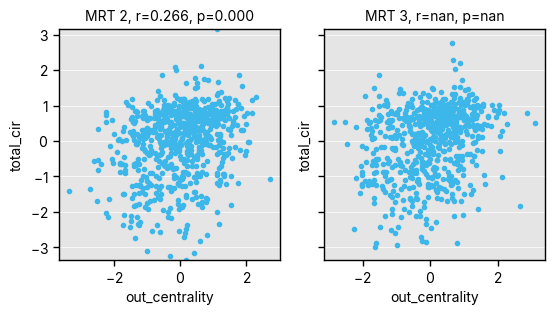

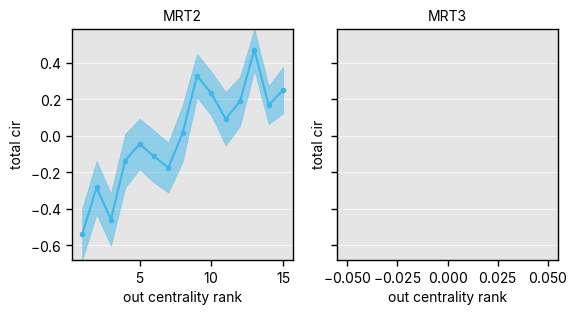

In [20]:
from scipy import stats

take_absolute_cir = True
cir = kalman_cir
out_centrality = kalman_out_centrality

with PaperStyle():
    fig1, axes1 = plt.subplots(1, 2, figsize=(6.27, 3), sharey=True)
    fig2, axes2 = plt.subplots(1, 2, figsize=(6.27, 3), sharey=True)
    for m, mrt in enumerate(MRT):
        valid_map = ~cir[m].mean(2).isnan().any(1)
        z_out_centrality = (out_centrality[m] - out_centrality[m].mean(1, keepdim=True)) / out_centrality[m].std(1, keepdim=True)
        z_out_centrality = z_out_centrality[valid_map]
        if take_absolute_cir:
            abs_cir_mean = tc.abs(cir[m]).mean(2)[valid_map]
            z_total_cir = (abs_cir_mean - abs_cir_mean.mean(1, keepdim=True)) / abs_cir_mean.std(1, keepdim=True)
        else:
            cir_mean = cir[m].mean(2)[valid_map]
            z_total_cir = (cir_mean -cir_mean.mean(1, keepdim=True)) / cir_mean.std(1, keepdim=True)        
        pearsonr = stats.pearsonr(z_out_centrality.flatten(), z_total_cir.flatten())
        r, p = pearsonr.correlation, pearsonr.pvalue
        axes1[m].plot(z_out_centrality.flatten(), z_total_cir.flatten(), linestyle='', marker='.')
        axes1[m].set(xlabel='out_centrality', ylabel='total_cir', title=f'MRT {mrt}, r={r:.3f}, p={p:.3f}')

        ordered_cir_mean = z_total_cir.take_along_dim(z_out_centrality.argsort(), dim=1)
        ordered_cir_mean_mean = ordered_cir_mean.mean(0)
        ordered_cir_mean_sem = ordered_cir_mean.std(0) / math.sqrt(ordered_cir_mean.shape[0])
        spearmanr = stats.spearmanr(range(ordered_cir_mean.shape[1]), ordered_cir_mean_mean)
        r, p = spearmanr.correlation, spearmanr.pvalue
        axes2[m].plot(tc.arange(ordered_cir_mean.shape[1])+1, ordered_cir_mean_mean, linestyle='-', marker='.', color=color_cycle[m])
        axes2[m].fill_between(tc.arange(ordered_cir_mean.shape[1])+1, ordered_cir_mean_mean - ordered_cir_mean_sem, ordered_cir_mean_mean + ordered_cir_mean_sem, alpha=0.5, color=color_cycle[m])
        axes2[m].set(xlabel='out centrality rank', ylabel='total cir', title=f'MRT{mrt}')
    fig2.savefig(f'../results/_paper/network_perturbation_analyses/kalman_cir_vs_out_centrality_rank.pdf')
    plt.show()

Plot cumulative impulse response of node with highest and lowest out centrality

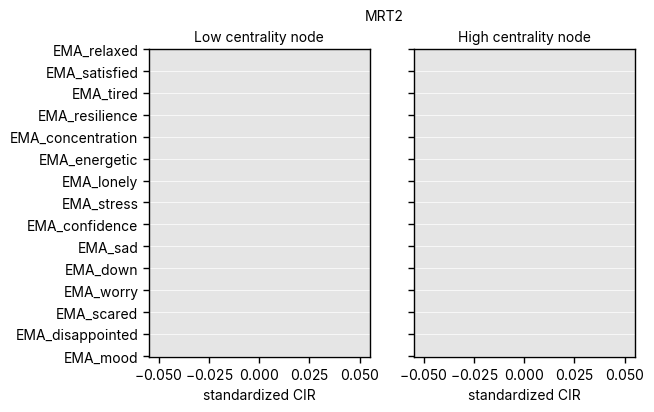

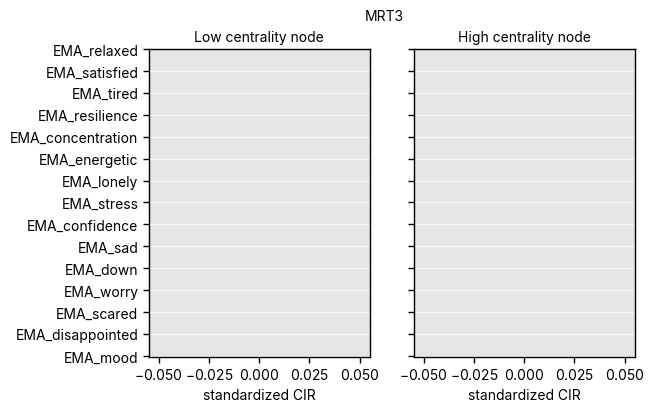

In [21]:
import math
from scipy import stats
import plotting_utils

take_absolute_cir = True
cir = kalman_cir
out_centrality = kalman_out_centrality

with PaperStyle():

    for m, mrt in enumerate(MRT):
        fig, axes = plt.subplots(1, 2, figsize=(6.27, 4), sharey=True, sharex=True)
        # valid_map = ~cir[m].mean(2).isnan().any(1)
        z_out_centrality = (out_centrality[m] - out_centrality[m].mean(1, keepdim=True)) / out_centrality[m].std(1, keepdim=True)  
        z_out_centrality = z_out_centrality
        if take_absolute_cir:
            abs_cir = tc.abs(cir[m])
            z_cir = (abs_cir - abs_cir.mean((1,2), keepdim=True)) / abs_cir.std((1,2), keepdim=True)
        else:
            z_cir = (cir[m] - cir[m].mean((1,2), keepdim=True)) / cir[m].std((1,2), keepdim=True)
        high_centrality_nodes = tc.argmax(z_out_centrality, dim=1)
        low_centrality_nodes = tc.argmin(z_out_centrality, dim=1)

        cir_of_high_centrality_nodes = z_cir[tc.arange(z_cir.shape[0]), high_centrality_nodes]
        cir_of_low_centrality_nodes = z_cir[tc.arange(z_cir.shape[0]), low_centrality_nodes]
        
        axes[0].barh(tc.arange(z_cir.shape[2]), cir_of_low_centrality_nodes.mean(0), xerr=stats.sem(cir_of_low_centrality_nodes, axis=0), color='#359B73')
        axes[0].set_yticks(range(z_cir.shape[2]), labels=LABELS)
        axes[0].set(title=f'Low centrality node', xlabel='standardized CIR')
        axes[1].barh(tc.arange(z_cir.shape[2]), cir_of_high_centrality_nodes.mean(0), xerr=stats.sem(cir_of_high_centrality_nodes, axis=0), color='#359B73')
        axes[1].set_yticks(range(z_cir.shape[2]), labels=LABELS)
        axes[1].set(title=f'High centrality node', xlabel='standardized CIR')
        fig.suptitle(f'MRT{mrt}')
        fig.savefig(f'../results/_paper/network_perturbation_analyses/kalman_cir_vs_out_centrality_mrt{mrt}.pdf')
    plt.show()
